In [217]:
# Online training of a logistic regression model
# using Assumed Density Filtering (ADF).
# We compare the ADF result with MCMC sampling
# For further details, see the ADF paper:
#   * O. Zoeter, "Bayesian Generalized Linear Models in a Terabyte World,"
#     2007 5th International Symposium on Image and Signal Processing and Analysis, 2007,
#     pp. 435-440, doi: 10.1109/ISPA.2007.4383733.
# of the posterior distribution
# Dependencies:
#   !pip install -qq jax_cosmo

# Author: Gerardo Durán-Martín (@gerdm)


import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml
from jax import random
from jax.scipy.stats import norm

try:
    from jax_cosmo.scipy import integrate
except ModuleNotFoundError:
    %pip install -qq jax_cosmo
    from jax_cosmo.scipy import integrate
from functools import partial

try:
    from jsl.demos import logreg_biclusters as demo
except ModuleNotFoundError:
    %pip install -qq jsl
    from jsl.demos import logreg_biclusters as demo

import probml_utils as pml

MCMC weights
[-1.72774299 -0.99745934 -0.83459178]

Laplace weights
[-1.67334858 -0.9210658  -0.74144526]



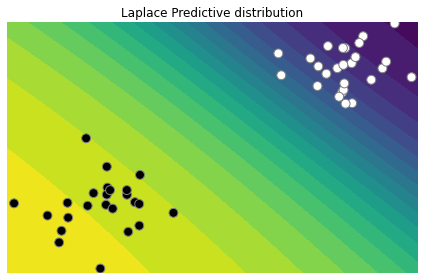

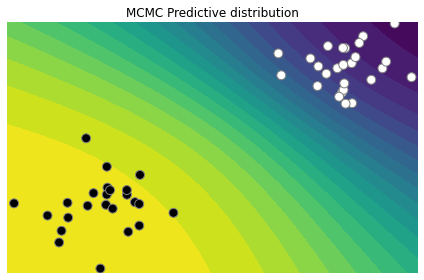

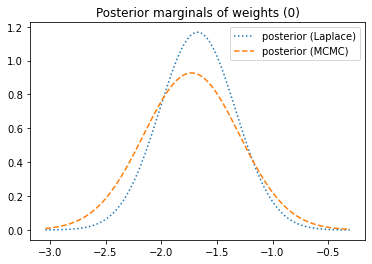

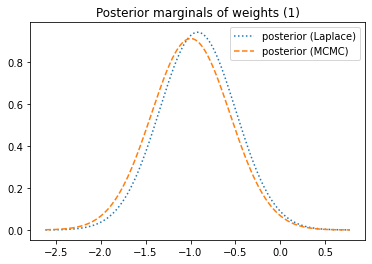

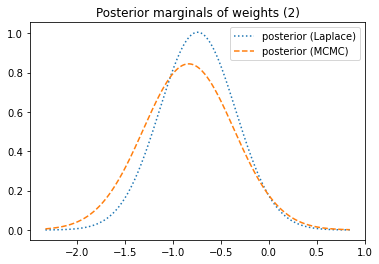

In [218]:
# cosmo seems to only support numerical integration in CPU mode
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

figures, data = demo.main()

X = data["X"]
y = data["y"]
Phi = data["Phi"]
Xspace = data["Xspace"]
Phispace = data["Phispace"]
w_laplace = data["w_laplace"]

$$
    \eta_t = \sigma({\bf w}_t^T {\bf x}_t) + q_t; q_t \sim \mathcal{N}(0, v_t)
$$

$$
    p({\bf w}_t \vert {\bf w}_{t-1}) = \prod_j\mathcal{N}(w_t^j \vert  \mu_{t \vert t-1}, \tau_{t \vert t-1}^j)
$$

In [229]:
def sigmoid(z):
    return jnp.exp(z) / (1 + jnp.exp(z))


def log_sigmoid(z):
    return z - jnp.log1p(jnp.exp(z))


def Zt_func(eta, y, mu, v):
    log_term = y * log_sigmoid(eta) + (1 - y) * jnp.log1p(-sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v)

    return jnp.exp(log_term)


def mt_func(eta, y, mu, v, Zt):
    log_term = y * log_sigmoid(eta) + (1 - y) * jnp.log1p(-sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v)

    return eta * jnp.exp(log_term) / Zt


def vt_func(eta, y, mu, v, Zt):
    log_term = y * log_sigmoid(eta) + (1 - y) * jnp.log1p(-sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v)

    return eta**2 * jnp.exp(log_term) / Zt


def adf_step(state, xs, prior_variance, lbound, ubound):
    mu_t, tau_t = state
    Phi_t, y_t = xs

    mu_t_cond = mu_t
    tau_t_cond = tau_t + prior_variance

    # prior predictive distribution
    m_t_cond = (Phi_t * mu_t_cond).sum()
    v_t_cond = (Phi_t ** 2 * tau_t_cond).sum()

    v_t_cond_sqrt = jnp.sqrt(v_t_cond)

    # Moment-matched Gaussian approximation elements
    Zt = integrate.romb(lambda eta: Zt_func(eta, y_t, m_t_cond, v_t_cond_sqrt), lbound, ubound)

    mt = integrate.romb(lambda eta: mt_func(eta, y_t, m_t_cond, v_t_cond_sqrt, Zt), lbound, ubound)

    vt = integrate.romb(lambda eta: vt_func(eta, y_t, m_t_cond, v_t_cond_sqrt, Zt), lbound, ubound)
    vt = vt - mt ** 2
    
    # Posterior estimation
    delta_m = mt - m_t_cond
    delta_v = vt - v_t_cond
    a = Phi_t * tau_t_cond / (Phi_t**2 + tau_t_cond).sum()
    
    mu_t = mu_t_cond + a * delta_m
    tau_t = tau_t_cond + a**2 * delta_v

    return (mu_t, tau_t), (mu_t, tau_t)

In [235]:
import numpy as np 
x, w = np.polynomial.hermite.hermgauss(3)

x, w = jnp.array(x), jnp.array(w)


In [239]:
def Zt_func(eta, y):
    log_term = y * log_sigmoid(eta) + (1 - y) * jnp.log1p(-sigmoid(eta))

    return jnp.exp(log_term)


def mt_func(eta, y, Zt):
    log_term = y * log_sigmoid(eta) + (1 - y) * jnp.log1p(-sigmoid(eta))

    return eta * jnp.exp(log_term) / Zt


def vt_func(eta, y, Zt):
    log_term = y * log_sigmoid(eta) + (1 - y) * jnp.log1p(-sigmoid(eta))

    return eta**2 * jnp.exp(log_term) / Zt


def adf_gh_step(state, xs, prior_variance, lbound, ubound):
    mu_t, tau_t = state
    Phi_t, y_t = xs

    mu_t_cond = mu_t
    tau_t_cond = tau_t + prior_variance

    # prior predictive distribution
    m_t_cond = (Phi_t * mu_t_cond).sum()
    v_t_cond = (Phi_t ** 2 * tau_t_cond).sum()

    v_t_cond_sqrt = jnp.sqrt(v_t_cond)

    # Moment-matched Gaussian approximation elements
    Zt = Zt_func(jnp.sqrt(2) * v_t_cond_sqrt * x + m_t_cond, y_t)
    Zt = (w * Zt).sum() / jnp.sqrt(np.pi)
    
    mt = mt_func(jnp.sqrt(2) * v_t_cond_sqrt * x + m_t_cond, y_t, Zt)
    mt = (w * mt).sum() / jnp.sqrt(np.pi)
    
    vt = vt_func(jnp.sqrt(2) * v_t_cond_sqrt * x + m_t_cond, y_t, Zt)
    vt = (w * vt).sum() / jnp.sqrt(np.pi)
    vt = vt - mt ** 2
    
    # Posterior estimation
    delta_m = mt - m_t_cond
    delta_v = vt - v_t_cond
    a = Phi_t * tau_t_cond / (Phi_t**2 + tau_t_cond).sum()
    
    mu_t = mu_t_cond + a * delta_m
    tau_t = tau_t_cond + a**2 * delta_v

    return (mu_t, tau_t), (mu_t, tau_t)

In [194]:
def adf_ustep(state, xs, prior_variance, lbound, ubound):
    mu_t, tau_t = state
    Phi_t, y_t = xs

    mu_t_cond = mu_t
    tau_t_cond = tau_t + prior_variance

    # prior predictive distribution
    m_t_cond = (Phi_t * mu_t_cond).sum()
    v_t_cond = (Phi_t ** 2 * tau_t_cond).sum()
    
    n = len(mu_t)
    # alpha, kappa = 1.0, 1.0
    alpha, kappa, beta = 0.001, 0.0, 0.1
    # lambda parameter: scale of the unscented transform
    uscale = alpha ** 2 * (n + kappa) - n
    
    # Build sigma points
    xi_0 = mu_t_cond[None, :]
    xi_1 = mu_t_cond[None, :] + jnp.sqrt(n + uscale) * jnp.diag(jnp.sqrt(tau_t_cond))
    xi_2 = mu_t_cond[None, :] - jnp.sqrt(n + uscale) * jnp.diag(jnp.sqrt(tau_t_cond))
    sigma_points = jnp.r_[xi_0, xi_1, xi_2]
    
    # weights
    w_0m = uscale / (n + uscale)
    w_0c = w_0m + (1 - alpha ** 2 + beta)
    
    w_m = jnp.concatenate([jnp.array(w_0m)[None], jnp.ones(2 * n) / (2 * (n + uscale))])
    w_c = jnp.concatenate([jnp.array(w_0c)[None], jnp.ones(2 * n) / (2 * (n + uscale))])
    
    y_est = jax.nn.sigmoid(jnp.einsum("m,sm->s", Phi_t, sigma_points) +  prior_variance)
    
    # Moments
    mt = jnp.sum(w_m * y_est)
    vt = jnp.sum(w_c * (y_est - mt) ** 2)
    
    # Posterior estimation
    delta_m = mt - m_t_cond
    delta_v = vt - v_t_cond
    a = Phi_t * tau_t_cond / (Phi_t**2 + tau_t_cond).sum()
    
    mu_t = mu_t_cond + a * delta_m
    tau_t = tau_t_cond + a ** 2 * delta_v

    return (mu_t, tau_t), (mu_t, tau_t)

In [240]:
# ** ADF inference **
prior_variance = 0.0
# Lower and upper bounds of integration. Ideally, we would like to
# integrate from -inf to inf, but we run into numerical issues.
n_datapoints, ndims = Phi.shape
lbound, ubound = -9, 9
mu_0 = jnp.zeros(ndims) * 0.0
tau_0 = jnp.ones(ndims) * 1.0

init_state = (mu_0, tau_0)
xs = (Phi, y)

adf_loop = partial(adf_gh_step, prior_variance=prior_variance, lbound=lbound, ubound=ubound)
(mu_t, tau_t), (mu_t_hist, tau_t_hist) = jax.lax.scan(adf_loop, init_state, xs)
print("ADF weights")
print(mu_t)

# ADF posterior predictive distribution
n_samples = 5000
key = random.PRNGKey(3141)
adf_samples = random.multivariate_normal(key, mu_t, jnp.diag(tau_t), (n_samples,))
Z_adf = sigmoid(jnp.einsum("mij,sm->sij", Phispace, adf_samples))
Z_adf = Z_adf.mean(axis=0)

# ** Plotting predictive distribution **
colors = ["black" if el else "red" for el in y]

## Add posterior marginal for ADF-estimated weights
for i in range(ndims):
    mean, std = mu_t[i], jnp.sqrt(tau_t[i])
    fig = figures[f"logistic_regression_weights_marginals_w{i}"]
    ax = fig.gca()
    x = jnp.linspace(mean - 4 * std, mean + 4 * std, 500)
    ax.plot(x, norm.pdf(x, mean, std), label="posterior (ADF)", linestyle="dashdot")
    ax.legend()

fig_adf, ax = plt.subplots()
title = "ADF Predictive distribution"
demo.plot_posterior_predictive(ax, X, Xspace, Z_adf, title, colors, cmap="viridis")
pml.savefig("logistic_regression_surface_adf.pdf")

# Posterior vs time

lcolors = ["black", "tab:blue", "tab:red"]
elements = mu_t_hist.T, tau_t_hist.T, w_laplace, lcolors
timesteps = jnp.arange(n_datapoints) + 1

for k, (wk, Pk, wk_laplace, c) in enumerate(zip(*elements)):
    fig_weight_k, ax = plt.subplots()
    ax.errorbar(timesteps, wk, jnp.sqrt(Pk), c=c, label=f"$w_{k}$ online (adf)")
    ax.axhline(y=wk_laplace, c=c, linestyle="dotted", label=f"$w_{k}$ batch (Laplace)", linewidth=3)

    ax.set_xlim(1, n_datapoints)
    ax.legend(framealpha=0.7, loc="upper right")
    ax.set_xlabel("number samples")
    ax.set_ylabel("weights")
    plt.tight_layout()
    pml.savefig(f"logistic_regression_hist_adf_w{k}")

plt.show()

TypeError: mul got incompatible shapes for broadcasting: (3,), (500,).